### Submission Instructions

Just fill in the markdown and code cells below with your arguments and functions, and run the Python lines given. Make sure the notebook works fine by executing `Kernel/Restart & Run All`.
  
Once the notebook is ready,
1. Create a folder named `mbd_last_name1_last_name2` with the team's last names.

2. Put in that folder:

* a file `mp_mbd_last_name1_last_name2.ipynb` with the cells below completed. Make sure it works by executing Kernel/Restart & Run All.
* a file `mp_mbd_last_name1_last_name2.html` with an html rendering of the previous .ipynb file (just apply File / Download as HTML after a correct run of Kernel/Restart & Run All).
* a file `mp_mbd_last_name1_last_name2.pdf` with a pdf print of the html file **without any code**.

3. Compress **the folder** to a `mbd_last_name1_last_name2.7z` 7z (or zip) file.

**Very important!!!**

Make sure you follow the file naming conventions above; the miniproject won't be graded until that is so.

## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

**IMPORTANT AND JUST IN CASE: before turning in your work, please REMOVE FROM IT THE PREVIOUS TWO CELLS**

In [26]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Wind Energy Prediction
We want to predict the wind energy production on a farm using wind speed and direction information.

The aim of this wind power forecasting problem is to predict the wind power generation 24 h ahead for a wind farm in Australia.

Attribute Information:
The features include forecasts of the projections of the wind vector on the west-east (U) and south-north (V) axes,at two heights, 10 and 100 m above ground level, plus the corresponding absolute wind speeds.

Data for approximatley a **nine month** period are given in a csv file with headers

`TIMESTAMP,TARGETVAR,U10,V10,U100,V100,v10,v100`

where

* TIMESTAMP contains day/hour information.
* TARGETVAR is the wind energy production normalized to a [0, 100] range.
* U10,V10,U100,V100 are the U and V wind components in m/s at heights 10 and 100.
* v10,v100 are the absolute wind speeds in m/s at heights 10 and 100.

The dataset we will use is an adaptation of those available in the Kaggle page https://www.kaggle.com/c/GEF2012-wind-forecasting. 

**You will observe that the structure and most of the coding is fairly standard.  
Because of this you should focus on streamlining cells and code, avoiding unnecessary elements, and also make a substantial effort on your analysis and conclusions.**

In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

## Data Loading

We load the csv file using its first column as a `datetime` index.

In [29]:
df_0 = pd.read_csv('w_e.csv', index_col=0, parse_dates=True)
l_vars = df_0.columns[1 : ]
print(l_vars)
df = df_0[l_vars]
df['target'] = df_0['TARGETVAR']

print ("nFilas: %d\tnColumnas: %d\n" % (df.shape[0], df.shape[1]) )
print ("Columnas:\t", np.array(df.columns))

Index(['U10', 'V10', 'U100', 'V100', 'v10', 'v100'], dtype='object')
nFilas: 6576	nColumnas: 7

Columnas:	 ['U10' 'V10' 'U100' 'V100' 'v10' 'v100' 'target']


In [30]:
df.index

DatetimeIndex(['2012-01-01 01:00:00', '2012-01-01 02:00:00',
               '2012-01-01 03:00:00', '2012-01-01 04:00:00',
               '2012-01-01 05:00:00', '2012-01-01 06:00:00',
               '2012-01-01 07:00:00', '2012-01-01 08:00:00',
               '2012-01-01 09:00:00', '2012-01-01 10:00:00',
               ...
               '2012-09-30 15:00:00', '2012-09-30 16:00:00',
               '2012-09-30 17:00:00', '2012-09-30 18:00:00',
               '2012-09-30 19:00:00', '2012-09-30 20:00:00',
               '2012-09-30 21:00:00', '2012-09-30 22:00:00',
               '2012-09-30 23:00:00', '2012-10-01 00:00:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=6576, freq=None)

## Descriptive analysis

In [31]:
df.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
U10,6576.0,0.93,2.55,-7.49,-1.09,0.78,2.48,11.12
V10,6576.0,-0.25,2.99,-9.99,-2.38,0.01,1.96,9.07
U100,6576.0,1.59,4.25,-10.91,-1.77,1.41,4.64,16.99
V100,6576.0,-0.48,5.13,-15.29,-4.80,0.30,3.61,14.31
v10,6576.0,3.63,1.78,0.12,2.20,3.33,4.79,11.74
v100,6576.0,6.33,2.65,0.08,4.43,6.18,8.00,18.49
target,6576.0,30.99,29.57,0.00,5.83,21.36,50.16,99.95


## Boxplots

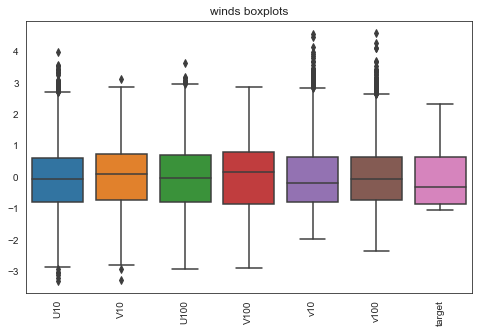

In [32]:
#normalizamos para tener rangos uniformes en histogramas
df_normalizado = (df - df.mean()) / df.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
#bxplot = sns.boxplot(data=df_housing)
boxplot = sns.boxplot(data=df_normalizado)
plt.title("winds boxplots")
plt.xticks(rotation=90)
plt.show()

## Histograms and scatterplots

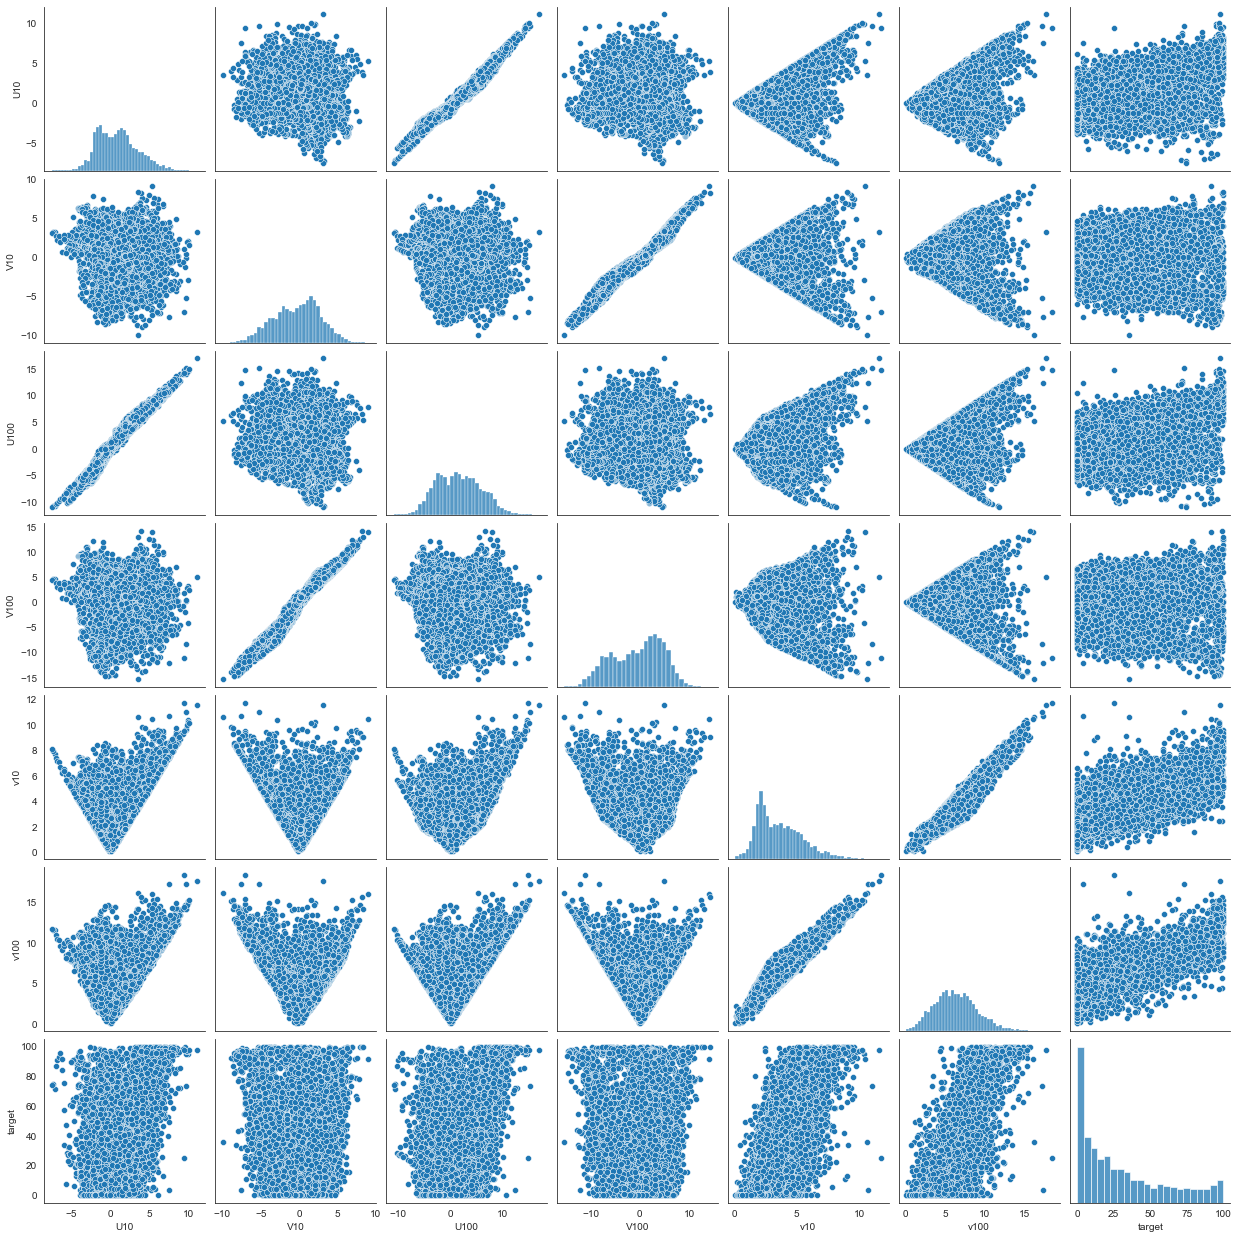

In [33]:
pair_plot = sns.pairplot( df[['U10', 'V10', 'U100', 'V100', 'v10', 'v100', 'target']]  )
plt.show()

## Correlations

In [34]:
df.corr().round(decimals=3)

,U10,V10,U100,V100,v10,v100,target
U10,1.000,-0.098,0.981,-0.058,0.441,0.392,0.377
V10,-0.098,1.000,-0.133,0.981,-0.162,-0.257,-0.166
U100,0.981,-0.133,1.000,-0.095,0.394,0.364,0.365
V100,-0.058,0.981,-0.095,1.000,-0.172,-0.279,-0.177
v10,0.441,-0.162,0.394,-0.172,1.000,0.915,0.706
v100,0.392,-0.257,0.364,-0.279,0.915,1.000,0.745
target,0.377,-0.166,0.365,-0.177,0.706,0.745,1.000


## Overall conclusions

# Ridge Regressor

Perform a CV estimation of a pipelined Ridge regressor over 9 folds over the entire sample **without shuffling**. This way each fold has approximately one month of data.

In [35]:
std_sc = StandardScaler()
x = std_sc.fit_transform(df.loc[:, df.columns != 'target'])
y = df['target'].iloc[0:]

In [36]:
rr = Ridge()
rr_pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                          ('rr', rr)])

n_folds = 9
kf = KFold(n_folds, shuffle=False)

# define param_grid
l_alpha = [10.**k for k in range(-6, 5)]
param_grid = {'rr__alpha': l_alpha}

cv_estimator= GridSearchCV(rr_pipe, 
                           param_grid=param_grid, 
                           cv=kf, 
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1, 
                           verbose=1)

_ = cv_estimator.fit(x, y)

Fitting 9 folds for each of 11 candidates, totalling 99 fits


## Analyzing GridSearchCV results

Check the adequacy of the best hyperparameters.

In [37]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator.cv_results_)

display(df_cv_estimator[["param_rr__alpha", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_rr__alpha,mean_test_score
8,100.0,-15.270111
7,10.0,-15.312163
6,1.0,-15.324377
5,0.1,-15.325790
4,0.01,-15.325934


alpha_range: 0 - 10000
alpha = 100
best_cv_mae = 15.270


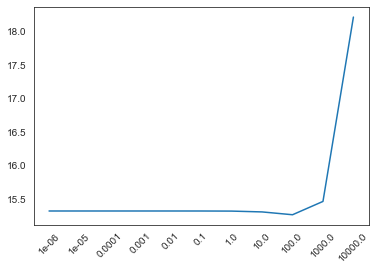

In [38]:
print("alpha_range: %.f - %.f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.f' % (cv_estimator.best_params_['rr__alpha']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -df_cv_estimator['mean_test_score'])

In [39]:
# Vemos que el score mas alto viene cuando alpha es cercano a 100. El problema es que el intervalo de valores es muy alto, por lo que para 
# afinar el score, utilizaremos 100 como valor medio de alfa donde explorar que valores tienen un mayor score
l_alpha = [cv_estimator.best_params_['rr__alpha'] + k for k in range(0, 100, 10)]
param_grid = {'rr__alpha': l_alpha}

cv_estimator_2= GridSearchCV(rr_pipe, 
                             param_grid=param_grid, 
                             cv=kf, 
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1, 
                             verbose=1)

_ = cv_estimator_2.fit(x, y)

Fitting 9 folds for each of 10 candidates, totalling 90 fits


,param_rr__alpha,mean_test_score
4,140.0,-15.267747
5,150.0,-15.267770
3,130.0,-15.267931
6,160.0,-15.267954
2,120.0,-15.268342


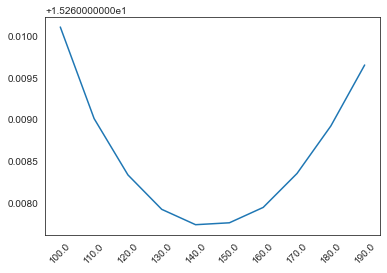

In [40]:
df_cv_estimator_2 = pd.DataFrame.from_dict(cv_estimator_2.cv_results_)

display(df_cv_estimator_2[["param_rr__alpha", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -df_cv_estimator_2['mean_test_score'])

## Testing the Ridge model

Do it over the entire dataset using `cross_val_predict`, get the CV MAE and draw the appropriate plots.

In [41]:
best_rr = cv_estimator_2.best_estimator_
rr_scores = cross_val_score(best_rr, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
print("ridge mae_mean: %.3f\t\tmae_std: %.3f" % (-rr_scores.mean(), rr_scores.std()))

ridge mae_mean: 15.268		mae_std: 2.130


## Ridge Residual histograms and relationship with targets

Show and discuss them.

ridge mae: 15.267


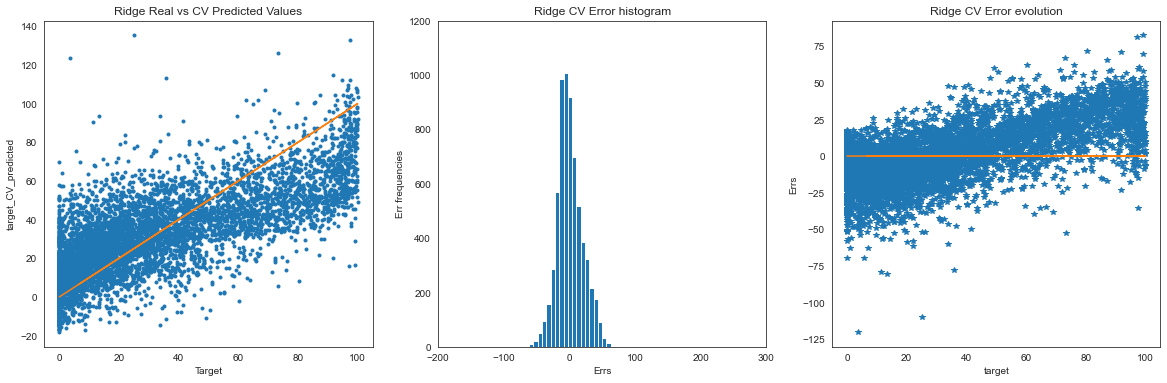

In [42]:
y_pred_rr = np.clip( cross_val_predict(best_rr, x, y, cv=kf, n_jobs=-1),-1000, +1800.)
err_rr = y - y_pred_rr

print("ridge mae: %.3f" % (abs(err_rr).mean()) )

plt.figure( figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Ridge Real vs CV Predicted Values')
plt.xlabel('Target')
plt.ylabel('target_CV_predicted')
_ = plt.plot(y, y_pred_rr, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title("Ridge CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-200, 300)
plt.ylim(0, 1200)
_ = plt.hist(err_rr, bins=31)

plt.subplot(1, 3, 3)
plt.title("Ridge CV Error evolution")
plt.xlabel("target")
plt.ylabel("Errs")
_ = plt.plot(y, err_rr, '*', y, 0.*y, '-')

## Conclusions on the base Ridge model

# Trying to improve the estimator

Me may try to improve the Ridge results in two different ways:
* first, by enlarging the features set with the **square and cube powers of the absolute velocities** and reapplying a Ridge model.
* second, by using these enlarged features but working with another model, the HuberRegressor (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html), using its default parameters and hyperparametrizing the `alpha` hyperparameter.

Redo the previous Ridge MLPR analysis and conclusions over the enlarged dataset with the same analysis structure previously used.

In [43]:
# Vamos a agrandar el  connjunto de datos que hay en el dataset. Para hacer esto, vamos a generar 4 nuevas columnas:
# - v10_square
# - v10_cube
# - v100_square
# - v100_cube

df['v10_square'] = df['v10']**2
df['v10_cube'] = df['v10']**3
df['v100_square'] = df['v100']**2
df['v100_cube'] = df['v 100']**3

# Ridge modeling over enlarged features

In [44]:
# Repetimos el proceso, pero ahora con el dataset "agrandado"
std_sc = StandardScaler()
x = std_sc.fit_transform(df.loc[:, df.columns != 'target'])
y = df['target'].iloc[0:]

In [45]:
rr = Ridge()
rr_pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                          ('rr', rr)])

n_folds = 9
kf = KFold(n_folds, shuffle=False)

# define param_grid
l_alpha = [10.**k for k in range(-6, 5)]
param_grid = {'rr__alpha': l_alpha}

cv_estimator_enlarged= GridSearchCV(rr_pipe, 
                           param_grid=param_grid, 
                           cv=kf, 
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1, 
                           verbose=1)

_ = cv_estimator_enlarged.fit(x, y)

Fitting 9 folds for each of 11 candidates, totalling 99 fits


In [46]:
best_rr = cv_estimator_enlarged.best_estimator_
rr_scores = cross_val_score(best_rr, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
print("ridge mae_mean: %.3f\t\tmae_std: %.3f" % (-rr_scores.mean(), rr_scores.std()))

ridge mae_mean: 14.243		mae_std: 2.239


ridge mae: 14.243


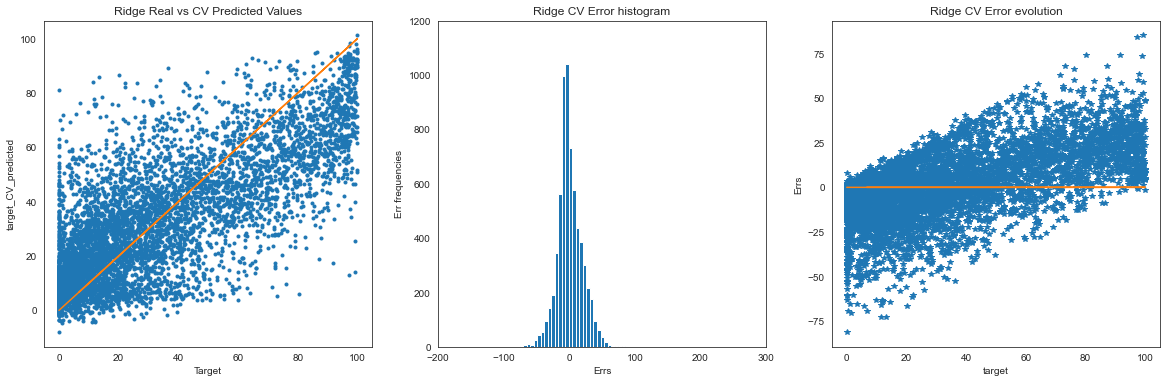

In [47]:
# Visualizamos los datos, de nuevo
y_pred_rr = np.clip( cross_val_predict(best_rr, x, y, cv=kf, n_jobs=-1),-1000, +1800.)
err_rr = y - y_pred_rr

print("ridge mae: %.3f" % (abs(err_rr).mean()) )

plt.figure( figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Ridge Real vs CV Predicted Values')
plt.xlabel('Target')
plt.ylabel('target_CV_predicted')
_ = plt.plot(y, y_pred_rr, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title("Ridge CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-200, 300)
plt.ylim(0, 1200)
_ = plt.hist(err_rr, bins=31)

plt.subplot(1, 3, 3)
plt.title("Ridge CV Error evolution")
plt.xlabel("target")
plt.ylabel("Errs")
_ = plt.plot(y, err_rr, '*', y, 0.*y, '-')

## Conclusions on the enlarged Ridge model

# Huber Regression  modeling over enlarged features

Apply a `HuberRegressor` model to the enlarged data and search for the optimal hyperparameter `alpha`.  

Its scikit-learn API is at 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor

## Conclusions on the enlarged Huber model

# Final conclusions

Joint discussion of the three models and their results.